# LQR Control of a Quadrotor

In this lab, we are going to use a hover state linearization of the quadrotor, like you wrote in the previous lab to allow the quadrotor to hover. First, we are going to import the various classes and functions we need.

In [21]:
from mae345 import plotting, Crazyflie as CF, animate_quad
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve_continuous_are
from IPython.display import HTML, Image

## Problem 1 (20 Pts)

Now, in the cell below, you will fillout the function that will actually solve the LQR problem. That is, given the matrices $\mathbf{A}, \mathbf{B}, \mathbf{Q}, \mathbf{R}$, you should compute the $K$ that minimizes the LQR cost function. You are encouraged to use the function `scipy.linalg.solve_continuous_are` to solve the CARE. Also, we use the convention that the stabilizing control input is given by $\mathbf{u} = \mathbf{K}\mathbf{x}$ (as opposed to $\mathbf{u} = -\mathbf{K}\mathbf{x}$).

In [22]:
def lqr(A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray) -> np.ndarray:
    P = solve_continuous_are(A, B, Q, R)
    K = -1 * np.matmul(np.matmul(np.linalg.inv(R), np.transpose(B)), P)
    return K

## Problem 2 (20 Pts)

Next, you will use all the code you have written thus far to actually stabilize your quadrotor in simulation. The following code implements a version of the Crazyflie (a quadrotor) class from our `mae345` library that uses the linearization and LQR functions you just wrote. This class is useful as it provides simulation and animation functionality to verify your controller is working. 

If we were working with the physical Crazyflie, we would load $\mathbf{K}$ for control. Additional tuning of the gains after tuning in simulation may be necessary when porting to hardware.


### LQR Design 

Here you will design the LQR controller and then simulate it.

The following cell uses the `lqr` function you just wrote in conjunction with our implementation of the linearization function from the previous lab (here as `self.hover_state_linearization()`) to create an instance of the `CrazyflieLQR` class. The details of this process are not important, but this class provides a lot of functionality for designing the LQR controller. 

In [23]:
class CrazyflieLQR(CF):
    def __init__(self, Q: np.ndarray, R: np.ndarray, hover_pos: np.ndarray):
        super().__init__()
        self._hover_pos = hover_pos
        self._hover_state = np.concatenate([self._hover_pos, np.zeros(9)])
        A, B =  self.hover_state_linearization()
        self._K = lqr(A, B, Q, R)
        
        print('Using K matrix:')
        print()
        print(self._K)
                
    @property
    def K(self) -> np.ndarray:
        return self._K
    
    def controller(self, state: np.ndarray, t: float) -> np.ndarray:
        return self._K @ (state - self._hover_state) + np.array([self.mass * self.gravity, 0, 0, 0])

    def set_goal_state(self, hover_state: np.ndarray):
        self._hover_state = hover_state        


### Problem 2: Part A (10 pts)
Provided below are untuned Q and R matrices. Tune these such that system stabilizes to a hover at $x = 0, y = 0, z = 0$ (within $\pm 0.025$) and with steady state angles $\phi=\theta=\psi=0$ (within $\pm 0.05$) in 3 seconds or less. (Hint: view the plots of the state variables using the untuned Q and R matrices to determine where improvement can be made. Example: if theta is not stabilizing well, crank up the fifth element on the diag of Q.)

In [72]:
# untuned Q and R
Q = np.diag([10, 10, 10, 0.0001, 0.0001, 0.0001, 100, 100, 1, 0.005, 0.005, 1])
R = 2 * np.diag([1e2, 1e6, 1e6, 1e2])

# tuned Q and R
Q = np.diag([100, 1000, 10, 0.0001, 0.0001, 10, 100, 100, 1, 0.005, 0.005, 1])
R = 2 * np.diag([1e2, 1e6, 1e6, 1e2])

quad = CrazyflieLQR(Q, R, np.zeros(3))

Using K matrix:

[[ 2.40295406e-15 -0.00000000e+00 -2.23606798e-01 -0.00000000e+00
  -1.26574161e-15 -0.00000000e+00  1.47135809e-15 -0.00000000e+00
  -1.35707066e-01 -0.00000000e+00  1.89204525e-16 -0.00000000e+00]
 [-0.00000000e+00 -2.23606798e-02 -0.00000000e+00 -9.69999465e-03
  -0.00000000e+00  1.97675513e-17 -0.00000000e+00 -9.70901616e-03
  -0.00000000e+00 -5.27127544e-04 -0.00000000e+00 -8.43455245e-21]
 [ 7.07106781e-03 -0.00000000e+00  2.30891421e-16 -0.00000000e+00
  -8.65874506e-03 -0.00000000e+00  7.90539177e-03 -0.00000000e+00
   4.02877121e-17 -0.00000000e+00 -4.96473684e-04 -0.00000000e+00]
 [-0.00000000e+00  7.79899575e-15 -0.00000000e+00  5.24278028e-16
  -0.00000000e+00 -2.23606798e-01 -0.00000000e+00  1.55266044e-15
  -0.00000000e+00 -4.02542071e-17 -0.00000000e+00 -7.08046650e-02]]


This next cell simulates the quadrotor flying with a random initial condition for five seconds and plots some of the states. Use the plots to verify that the system stabilizes and meets the performance objective.

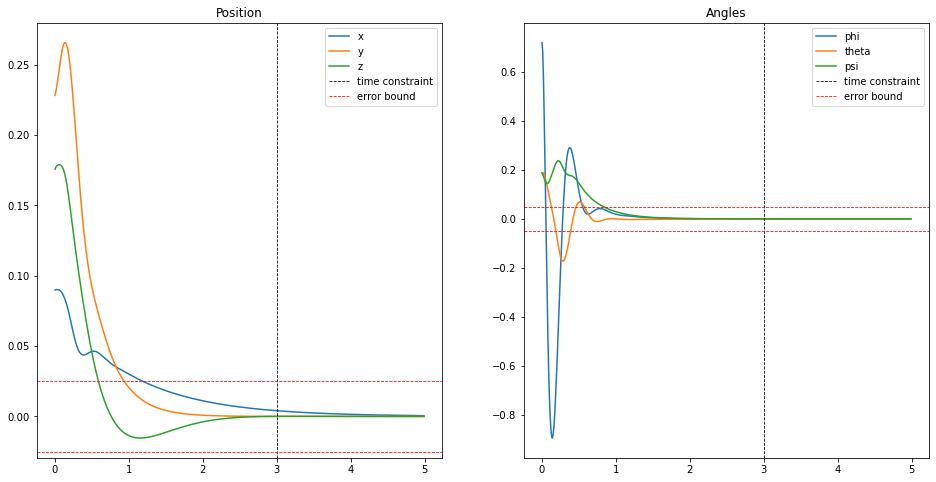

In [73]:
# Comment the following line if you want to do not want to use the same random initial condition.
np.random.seed(42)

ic = np.random.rand(12) * 1.2
ic[0:3] = ic[0:3] / 5
ic[6:9] = ic[6:9] / 5

times, states, inputs = quad.simulate(ic, 5, 0.01, clip_input=False)

#%matplotlib notebook
plt.rcParams["figure.figsize"] = (16,8)
fig = plt.figure()

ax = fig.add_subplot(121, title='Position')
ax.plot(times, states[0, :], label='x')
ax.plot(times, states[1, :], label='y')
ax.plot(times, states[2, :], label='z')
ax.axvline(x=3, linestyle='--', color='k', linewidth=0.8, label='time constraint')
ax.axhline(y=0.025, linestyle='--', color='r', linewidth=0.8, label='error bound')
ax.axhline(y=-0.025, linestyle='--', color='r', linewidth=0.8)
ax.legend()

ax = fig.add_subplot(122, title='Angles')
ax.plot(times, states[3, :], label='phi')
ax.plot(times, states[4, :], label='theta')
ax.plot(times, states[5, :], label='psi')
ax.axvline(x=3, linestyle='--', color='k', linewidth=0.8, label='time constraint')
ax.axhline(y=0.05, linestyle='--', color='r', linewidth=0.8, label='error bound')
ax.axhline(y=-0.05, linestyle='--', color='r', linewidth=0.8)
ax.legend()



This cell optionally animates the simulation data computed and plotted in the previous cell.

In [46]:
animate_quad(0.1, states).save('./anim.gif', writer='pillow', fps=100)
Image(url='./anim.gif')

## Describe the process you used to tune your gains.

I saw that x, y, psi were the only ones that required stabilizing, so i increase the 1st, 2nd, and 6th entries of the Q matrix by a factor of 10 unltil the system was stabilized in each direction. e.g. Once it was stabilized in x, but not for the rest,  I stopped increasing x but continued increasing y and psi gains. I did so until they were very stable at 3 seconds ( I could have stopped one iteration earlier for y and psi, but I kept going to show the difference between parts A and B more).

### Problem 2: Part B (10 pts)
Often times, it is important to keep your control effort minimal (e.g., to keep power consumption minimal). Now, tune Q and R to meet the same performance objectives in Part A within 4 seconds and with the control input never exceeding 0.32. Note that $m*g = 0.29$.

In [74]:
# tuned Q and R
Q = np.diag([25, 100, 10, 0.0001, 0.0001, 1, 100, 100, 1, 0.005, 0.005, 1])
R = 2 * np.diag([1e2, 1e6, 1e6, 1e2])

quad = CrazyflieLQR(Q, R, np.zeros(3))

Using K matrix:

[[ 4.09502359e-16 -0.00000000e+00 -2.23606798e-01 -0.00000000e+00
   1.38328146e-16 -0.00000000e+00 -3.00580412e-18 -0.00000000e+00
  -1.35707066e-01 -0.00000000e+00  2.60535947e-16 -0.00000000e+00]
 [-0.00000000e+00 -7.07106781e-03 -0.00000000e+00 -8.68106625e-03
  -0.00000000e+00  3.98694187e-18 -0.00000000e+00 -7.90742880e-03
  -0.00000000e+00 -4.98936979e-04 -0.00000000e+00  8.17851629e-20]
 [ 3.53553391e-03 -0.00000000e+00  2.37444118e-16 -0.00000000e+00
  -8.41953064e-03 -0.00000000e+00  7.48832474e-03 -0.00000000e+00
   5.54764598e-17 -0.00000000e+00 -4.89638167e-04 -0.00000000e+00]
 [-0.00000000e+00  1.38255539e-14 -0.00000000e+00  1.03087825e-14
  -0.00000000e+00 -7.07106781e-02 -0.00000000e+00  1.24049277e-14
  -0.00000000e+00  3.90322653e-16 -0.00000000e+00 -7.07404129e-02]]


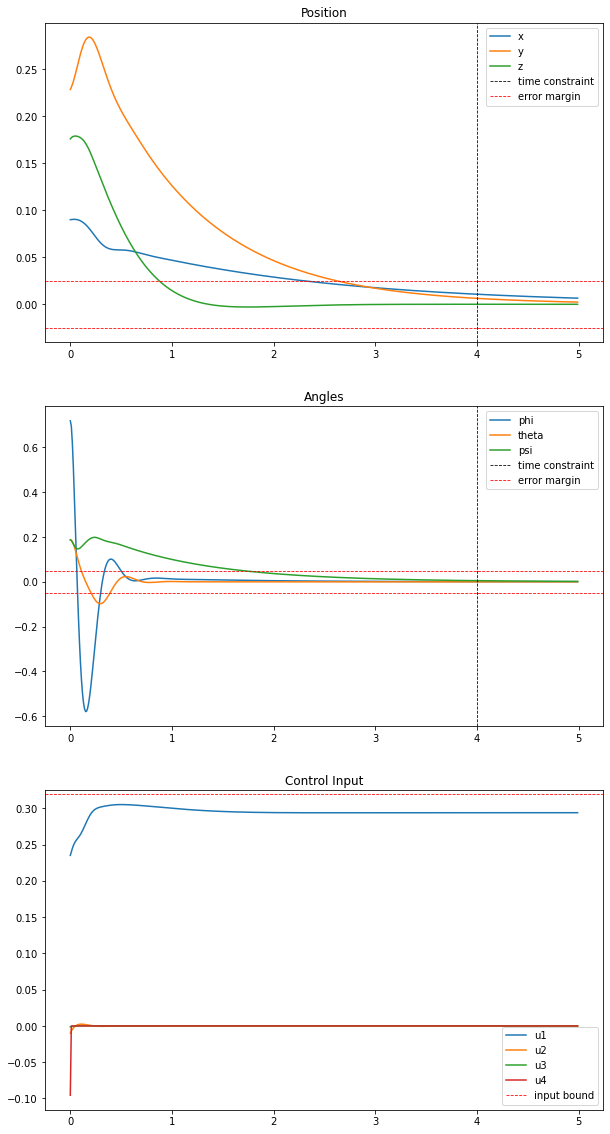

In [75]:
# Comment the following line if you want to do not want to use the same random initial condition.
np.random.seed(42)

ic = np.random.rand(12) * 1.2
ic[0:3] = ic[0:3] / 5
ic[6:9] = ic[6:9] / 5

times, states, inputs = quad.simulate(ic, 5, 0.01, clip_input=False)

#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10, 20)
fig = plt.figure()

ax = fig.add_subplot(311, title='Position')
ax.plot(times, states[0, :], label='x')
ax.plot(times, states[1, :], label='y')
ax.plot(times, states[2, :], label='z')
ax.axvline(x=4, linestyle='--', color='k', linewidth=0.8, label='time constraint')
ax.axhline(y=0.025, linestyle='--', color='r', linewidth=0.8, label='error margin')
ax.axhline(y=-0.025, linestyle='--', color='r', linewidth=0.8)
ax.legend()

ax = fig.add_subplot(312, title='Angles')
ax.plot(times, states[3, :], label='phi')
ax.plot(times, states[4, :], label='theta')
ax.plot(times, states[5, :], label='psi')
ax.axvline(x=4, linestyle='--', color='k', linewidth=0.8, label='time constraint')
ax.axhline(y=0.05, linestyle='--', color='r', linewidth=0.8, label='error margin')
ax.axhline(y=-0.05, linestyle='--', color='r', linewidth=0.8)
ax.legend()

ax = fig.add_subplot(313, title='Control Input')
ax.plot(times, inputs[0, :], label='u1')
ax.plot(times, inputs[1, :], label='u2')
ax.plot(times, inputs[2, :], label='u3')
ax.plot(times, inputs[3, :], label='u4')
ax.axhline(y=0.32, linestyle='--', color='r', linewidth=0.8, label='input bound')
ax.legend()

In [ ]:
animate_quad(0.1, states).save('./anim.gif', writer='pillow', fps=100)
Image(url='./anim.gif')

## Describe the process you used to tune your gains.

I did the same thing as before (part A) but now when I hit the stabilization for the first time, I did not go further (thus for y I left it at 100, for psi I left it at 1). I also decreased x by half and then by half again of what I did in part A. If i go below 20, it does not work, so i stopped at 25.

## Problem 3 (25 pts)

Next, we will use our tuned LQR controller (from either problem 2a or 2b) to not just hover, but follow a trajectory. In this problem, we will try to follow the path of a 3-D parametric curve given by the following equations:

$$\begin{align} x(t) = t, y(t) = sin(2t), z(t) = cos(2t)  \end{align}$$

This corresponds to circling in the y and z plane, while moving at a constant speed in the x direction: spiraling in the +x direction. In order to follow this path, we will need to make it into a series of waypoints, and then use LQR to follow them consecutively. 

### Problem 3: Part A (10 pts)

Create a series of 30 waypoints for the **state** of the quadrotor. Note that the state vector includes 12 states, and we may want to specify more than just the position at a given time. The time should range from $t = 0$ to $t = 3*\pi$

In [424]:
num_waypoints = 30
num_states = 12
total_time = 3 * np.pi

times = np.linspace(0, total_time, num_waypoints)
waypoints = np.zeros((num_waypoints, num_states))

for i in range(num_waypoints):
        
    t = times[i]
    #waypoints[i] = [x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, p, q, r]
    waypoints[i] = [t, np.sin(2 * t), np.cos(2 * t), 0, 0, 0, 1, 2 * np.cos(2 * t),
                    -2 * np.sin(2 * t), 0, 0, 0]

### Problem 3: Part B (15 pts)

#### B.i (5 pts)
First we must write the code that will follow the way points. We begin by hovering for 1 second to stabilize from the randomized initial condition. Then, we can accomplish movement by telling our LQR controller to, instead of hovering, go to the next waypoint for the amount of time in a timestep. We carry on through the waypoints sequentially until we run out of waypoints. Note that `CrazyflieLQR` class function `set_goal_state` will change the LQR's goal state. 

In order to complete your simulation, you will need to use quad.simulate(). This function takes the following inputs:

    ic: A 12-dimensional vector specifying the initial condition of the system.
    duration: The duration of the simulated trajectory.
    timestep: The timestep to use for the simulation. If None, solve_ivp determines the steps.
    clip_input: If True, the input is clipped using ``clipped_controller``. Otherwise unclipped
                           signal is used.
                  
                  
And returns the following outputs: 

    A tuple (t, x, u), where t is a vector containing the times at which the trajectory was evaluated,
    x is a matrix containing the corresponding states as columns
    and u is a matrix containing the corresponding inputs as columns.

#### B.ii (10 pts)
Then, tune the Q and R matricies such that the total distance to the goal position on the parametric trajectory doesn't exceed $0.5$ at any point in time. The matplotlib below will show you useful information once you've completed part B.i

In [506]:
# tuned Q and R
Q = np.diag([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 1, 1, 1, 0.0001, 
             0.0001, 0.0001])
R = 2 * np.diag([1e2, 1e5, 1e0, 1e0])
quad = CrazyflieLQR(Q, R, np.zeros(3))

Using K matrix:

[[ 3.81866153e-17 -0.00000000e+00 -7.07106781e-04 -0.00000000e+00
  -2.32610397e-18 -0.00000000e+00  2.31227167e-18 -0.00000000e+00
  -7.10100444e-02 -0.00000000e+00 -1.15636886e-21 -0.00000000e+00]
 [-0.00000000e+00 -2.23606798e-05 -0.00000000e+00 -3.80126628e-03
  -0.00000000e+00 -5.03519149e-22 -0.00000000e+00 -2.23994346e-03
  -0.00000000e+00 -3.29257266e-04 -0.00000000e+00 -6.48237671e-22]
 [ 7.07106781e-03 -0.00000000e+00 -2.27739338e-16 -0.00000000e+00
  -3.26709765e-01 -0.00000000e+00  7.07440080e-01 -0.00000000e+00
  -2.46228021e-16 -0.00000000e+00 -7.69454533e-03 -0.00000000e+00]
 [-0.00000000e+00 -4.15053843e-18 -0.00000000e+00 -5.34754439e-16
  -0.00000000e+00 -7.07106781e-03 -0.00000000e+00 -5.85897911e-16
  -0.00000000e+00 -3.09373777e-17 -0.00000000e+00 -7.10074653e-03]]


In [507]:
# Comment the following line if you want to do not want to use the same random initial condition.
np.random.seed(42)

ic = np.random.rand(12)
ic[0:3] = ic[0:3] / 20 + np.array([0,0,1])
ic[3:] = ic[3:] / 10

# set_goal_state takes the desired state vector at each time as input
quad.set_goal_state(np.concatenate([np.array([0,0,1]), np.zeros(9)]))
times, states, inputs = quad.simulate(ic, 1, 0.01, clip_input=True)

In [508]:
for i in range(num_waypoints - 1):
    # Fill in code to follow waypoints here
    quad.set_goal_state(waypoints[i + 1])
    times_temp, states_temp, inputs_temp = quad.simulate(waypoints[i], 
                                total_time/num_waypoints, None, clip_input=True)
    
    times = np.append(times, times_temp + times[-1]) 
    states = np.append(states, states_temp, axis=1)
    inputs = np.append(inputs, inputs_temp, axis=1)

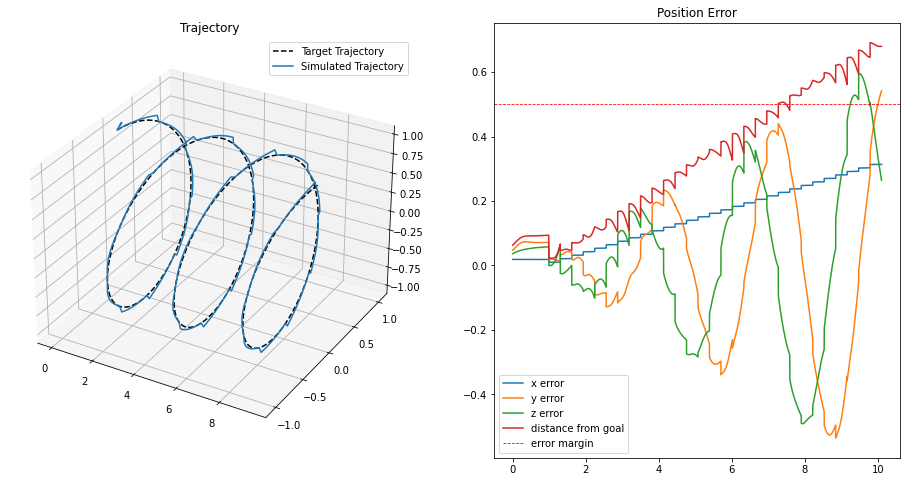

In [509]:
#matplotlib notebook
plt.rcParams["figure.figsize"] = (16,8)
fig = plt.figure()

ax = fig.add_subplot(121, title='Trajectory', projection='3d')
#ax = ax.axes(projection='3d')
xline = np.linspace(0, 3*np.pi, 1000)
yline = np.sin(2*xline)
zline = np.cos(2*xline)
ax.plot(xline, yline, zline, '--k',label = 'Target Trajectory')
ax.plot(states[0,:], states[1,:], states[2,:], label = 'Simulated Trajectory')
ax.legend()

ax = fig.add_subplot(122, title='Position Error')
x_state = np.copy(states[0, :])
x_state[100:] -= times[100:]-1
y_state = np.copy(states[1, :])
y_state[100:] -= np.sin(2*(times[100:]-1))
z_state = np.copy(states[2, :])
z_state[:100] -= 1
z_state[100:] -= np.cos(2*(times[100:]-1))
ax.plot(times, x_state, label='x error')
ax.plot(times, y_state, label='y error')
ax.plot(times, z_state, label='z error')
ax.plot(times, np.sqrt(x_state**2 + y_state**2 + z_state**2), label='distance from goal') 
ax.axhline(y=0.5, linestyle='--', color='r', linewidth=0.8, label='error margin')
ax.legend()

In [465]:
animate_quad(0.1, states).save('./anim.gif', writer='pillow', fps=100)
Image(url='./anim.gif')

Exception ignored in: <function TimerBase.__del__ at 0x7f82d09091f0>
Traceback (most recent call last):
  File "/Users/Sasha/miniconda3/envs/mae345/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1096, in __del__
    def __del__(self):
KeyboardInterrupt: 


## Describe the process you used to tune your gains.

I first set gains for the agles and pqr to almost 0 since I am not changing the roll, pitch, yaw in my trajectory. I then decided to put a high gain on R for the x-axis momentum since I want it to stay on the spiral path. I did not care as much for the moments about z and y axes, and increasing gains there past the small penalty for error did not help. I also put a 1e2 gain on the thrust since I do not want to los thrust and have "spikes" off of my trajectory. So that is how R was tuned.
Q was tuned by looking at the resulting graphs. having small gains for x, y, z and their derivatives made the trajectory as smooth as I could get and following the general spiral shapes. small gains reduce the sizes of the "spikes" that you can see along the trajectory. These spikes are likely caused dues to quadrotor picking a line to follow along each waypoint since we kept angles constant and it created a certain singularity for a quadrotor for moving at an angle. Because of that, my error in y and z looks sinusoidal, but my overall trajectory looks very close to the spiral (it is just a bit "jigsaw-y").